In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# load aggregated data without emptying intervals
df_garbage_agg = pd.read_csv("cleaned_data_agg_v1.csv")
container_agg = df_garbage_agg.loc[df_garbage_agg["container_id"]==1]
container_agg = container_agg.rename(columns={"hight_delta": "height_delta"})

In [3]:
data = container_agg["height_delta"]
data = pd.DataFrame(data)

In [4]:
# cummulative sum of height delta
data["cum_height"] = np.cumsum(data["height_delta"])

In [5]:
# add measurements per hour to dataframe so we can train our model with an x-Value
data["measurements"] = range(0, len(data.index.values))

In [6]:
data = data.reset_index()

### Model - fitting line to data

In [7]:
#20% testing, 80% training
set_len = int(np.round(len(data)*0.8))

In [8]:
train = data[:set_len]
test = data[set_len:]

In [9]:
# model training
model = LinearRegression().fit(train[["measurements"]], train[["cum_height"]])

In [10]:
# equation of the fitted line
m = model.coef_[0]
b = model.intercept_
print ('y = ', round(m[0],2), 'x + ', round(b[0],2))

y =  -17.62 x +  131.0


In [11]:
# create prediction values
prediction = model.predict(train[["measurements"]])

In [12]:
train["prediction"] = prediction

<ipython-input-12-6a8b582359e6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["prediction"] = prediction


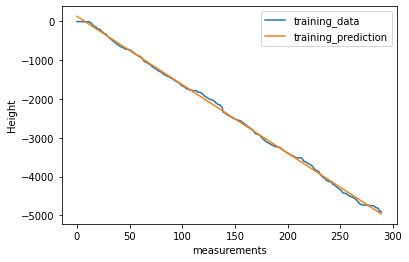

In [13]:
labels = ["training_data", "training_prediction"]
plt.xlabel("measurements")
plt.ylabel("Height")
plt.plot(train["cum_height"])
plt.plot(train["prediction"])
plt.legend(labels)
plt.show()

In [14]:
# evaluate model with MAE
np.mean(np.abs(train["cum_height"] - train["prediction"]))

41.834309814833915

In [15]:
# Testing model with unknown test dataset
prediction2 = model.predict(test[["measurements"]])
test["prediction"] = prediction2

<ipython-input-15-56926fecf6dc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediction"] = prediction2


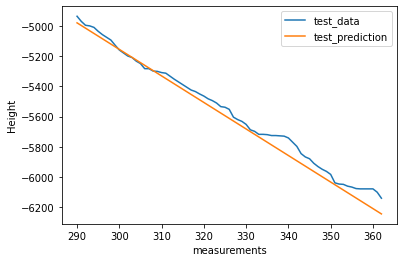

In [16]:
labels = ["test_data", "test_prediction"]
plt.xlabel("measurements")
plt.ylabel("Height")
plt.plot(test["cum_height"],)
plt.plot(test["prediction"])
plt.legend(labels)
plt.show()

In [17]:
# evaluate model with MAE
np.mean(np.abs(test["cum_height"] - test["prediction"]))

44.84650607731561

In [18]:
# create + 14 days for forecast in new data frame
ticks = pd.Series(range(0, len(data.index.values)+14))
data1 = pd.DataFrame()
data1[["cum_height", "measurements"]] = pd.concat([data["cum_height"],ticks], ignore_index=True, axis=1)

In [19]:
# create new model including all data we've got
model_2 = LinearRegression().fit(data[["measurements"]], data[["cum_height"]]) 

#equation of the fitted line
m = model_2.coef_[0]
b = model_2.intercept_
print ('y = ', round(m[0],2), 'x + ', round(b[0],2))

y =  -17.49 x +  117.35


In [20]:
data1["forecast"] = model_2.predict(data1[["measurements"]])

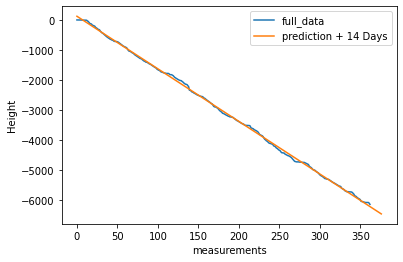

In [21]:
labels = ["full_data", "prediction + 14 Days"]
plt.xlabel("measurements")
plt.ylabel("Height")
plt.plot(data["cum_height"])
plt.plot(data1["forecast"])
plt.legend(labels)
plt.show()

In [22]:
# since we know the slope (m) of our fitted line we can simply reconstruct emptying intervalls for example: if height <=20
# start at height = 140 (container is empty)

interval = [140]
for i in range(1,30):
    if interval[i-1] <= 20:
        interval.append(140) # leerung
    else:
        interval.append(interval[i-1]+m)


C:\Users\alexa\.virtualenvs\bda-analytics-challenge-Bk2p0L_m\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


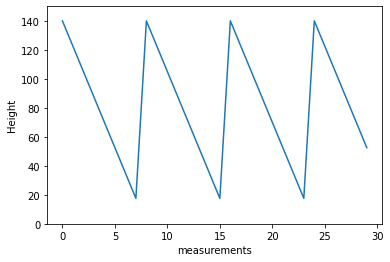

In [23]:
plt.xlabel("measurements")
plt.ylabel("Height")
plt.plot(interval)
plt.ylim(0,150)
plt.show()